In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from sklearn.svm import LinearSVR

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


%load_ext lab_black
%matplotlib inline

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [120]:
train = pd.read_csv("../data/raw/train.csv")
test = pd.read_csv("../data/raw/test.csv")
revealed_test = pd.read_csv("../data/raw/revealed_test.csv")

In [84]:
census = pd.read_csv("../data/raw/census_starter.csv")

In [85]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [133]:
revealed_test.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2022-11-01,1001,Autauga County,Alabama,2022-11-01,3.442677,1463
1,1001_2022-12-01,1001,Autauga County,Alabama,2022-12-01,3.470915,1475
2,1003_2022-11-01,1003,Baldwin County,Alabama,2022-11-01,8.257636,14145
3,1003_2022-12-01,1003,Baldwin County,Alabama,2022-12-01,8.250630,14133
4,1005_2022-11-01,1005,Barbour County,Alabama,2022-11-01,1.247223,247


In [87]:
train = (
    pd.concat([train, revealed_test], axis=0)
    .sort_values(by=["cfips", "first_day_of_month"])
    .reset_index(drop=True)
)

In [88]:
train["first_day_of_month"] = pd.to_datetime(train["first_day_of_month"])
train["population"] = train["active"] * 100 / train["microbusiness_density"]

In [89]:
ids = train["cfips"].values

In [90]:
outliers = []
cnt = 0
for o in tqdm(train.cfips.unique()):
    indices = train["cfips"] == o
    tmp = train.loc[indices].copy().reset_index(drop=True)
    var = tmp.microbusiness_density.values.copy()
    # vmax = np.max(var[:38]) - np.min(var[:38])

    for i in range(37, 2, -1):
        thr = 0.20 * np.mean(var[:i])
        difa = abs(var[i] - var[i - 1])
        if difa >= thr:
            var[:i] *= var[i] / var[i - 1]
            outliers.append(o)
            cnt += 1
    var[0] = var[1] * 0.99
    train.loc[indices, "microbusiness_density_smooth"] = var

outliers = np.unique(outliers)
len(outliers), cnt

C:\Users\joses\AppData\Local\Temp\ipykernel_5276\988193450.py:13: RuntimeWarning: invalid value encountered in scalar divide
  var[:i] *= var[i] / var[i - 1]
C:\Users\joses\AppData\Local\Temp\ipykernel_5276\988193450.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  var[:i] *= var[i] / var[i - 1]
C:\Users\joses\AppData\Local\Temp\ipykernel_5276\988193450.py:13: RuntimeWarning: invalid value encountered in multiply
  var[:i] *= var[i] / var[i - 1]
C:\Users\joses\AppData\Local\Temp\ipykernel_5276\988193450.py:11: RuntimeWarning: invalid value encountered in scalar subtract
  difa = abs(var[i] - var[i - 1])
100%|██████████| 3135/3135 [00:03<00:00, 1043.73it/s]


(481, 732)

In [91]:
# find microbusiness density smooth which equals inf and replace with previous value
for o in tqdm(train.cfips.unique()):
    indices = train["cfips"] == o
    tmp = train.loc[indices].copy().reset_index(drop=True)
    var = tmp.microbusiness_density_smooth.values.copy()
    for i in range(37):
        if var[i] == np.inf:
            var[i] = var[i - 1]
    train.loc[indices, "microbusiness_density_smooth"] = var

100%|██████████| 3135/3135 [00:02<00:00, 1423.40it/s]


In [92]:
train.isna().sum()

row_id                           0
cfips                            0
county                           0
state                            0
first_day_of_month               0
microbusiness_density            0
active                           0
population                      27
microbusiness_density_smooth    32
dtype: int64

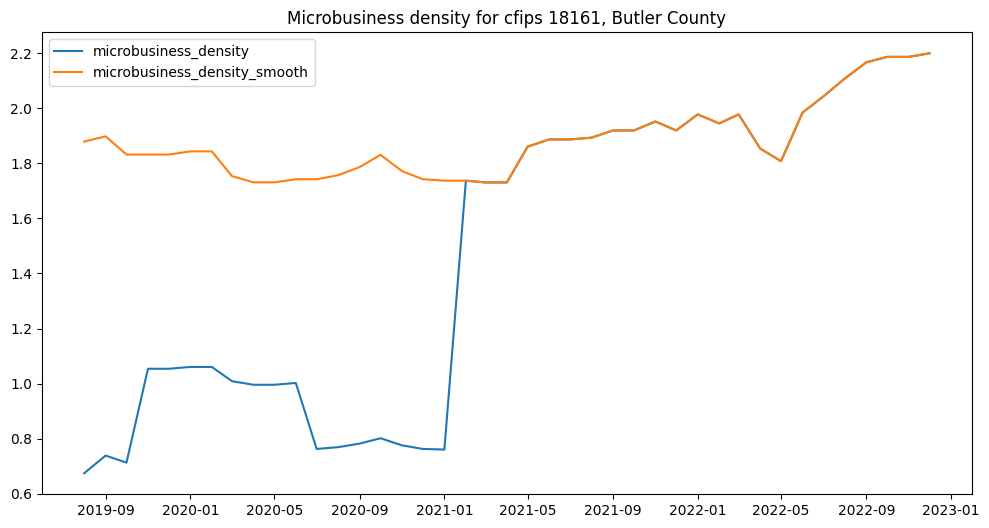

In [93]:
# Plot some microbusiness density


fig, ax = plt.subplots(1, 1, figsize=(12, 6))
id = np.random.choice(ids)
temp = train[train["cfips"] == 1013]
ax.plot(
    temp["first_day_of_month"],
    temp["microbusiness_density"],
    label="microbusiness_density",
)
ax.plot(
    temp["first_day_of_month"],
    temp["microbusiness_density_smooth"],
    label="microbusiness_density_smooth",
)

ax.legend()
plt.title(f"Microbusiness density for cfips {id}, {temp['county'].values[0]}")
plt.show()

## Create Timeseries

In [94]:
# Create an empty list to store the new time series
time_series = []

# Loop over each cfips
for cfips in train["cfips"].unique():
    # Filter the data for the current cfips
    train_cfips = train[train["cfips"] == cfips].reset_index(drop=True)
    # Loop over the time series from 0 to 14 (inclusive)
    for i in range(0, 17):
        # Create a new time series with the values for the current cfips and range of first_day_of_month
        time_series.append(
            {
                "cfips": cfips,
                "population": train_cfips.loc[i + 23, "population"],
                "active": train_cfips.loc[i + 23, "active"],
                "microbusiness_density": train_cfips.loc[
                    i : i + 23, "microbusiness_density"
                ].values.tolist(),
                "microbusiness_density_smooth": train_cfips.loc[
                    i : i + 23, "microbusiness_density_smooth"
                ].values.tolist(),
                # as target we are using the original microbusiness density
                "target": train_cfips.loc[i + 24, "microbusiness_density"],
                "target_date": train_cfips.loc[i + 24, "first_day_of_month"],
            }
        )

In [95]:
# Create a new dataframe with the list of time series
new_df = pd.DataFrame(time_series)

In [96]:
# merge with census data
new_df = new_df.merge(census, on="cfips", how="left")
new_df.head(40)

,cfips,population,active,microbusiness_density,microbusiness_density_smooth,target,target_date,pct_bb_2017,pct_bb_2018,pct_bb_2019,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,1001,42174.998960,1354,"[3.0076818, 2.8848701, 3.0558431, 2.9932332, 2...","[2.8560213990000003, 2.8848701, 3.0558431, 2.9...",3.219917,2021-08-01,76.6,78.9,80.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,1001,42174.998853,1358,"[2.8848701, 3.0558431, 2.9932332, 2.9932332, 2...","[2.8848701, 3.0558431, 2.9932332, 2.9932332, 2...",3.186722,2021-09-01,76.6,78.9,80.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
2,1001,42174.999890,1344,"[3.0558431, 2.9932332, 2.9932332, 2.96909, 2.9...","[3.0558431, 2.9932332, 2.9932332, 2.96909, 2.9...",3.203320,2021-10-01,76.6,78.9,80.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
3,1001,42175.000027,1351,"[2.9932332, 2.9932332, 2.96909, 2.9093256, 2.9...","[2.9932332, 2.9932332, 2.96909, 2.9093256, 2.9...",3.200948,2021-11-01,76.6,78.9,80.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
4,1001,42174.999067,1350,"[2.9932332, 2.96909, 2.9093256, 2.9332314, 3.0...","[2.9932332, 2.96909, 2.9093256, 2.9332314, 3.0...",3.286307,2021-12-01,76.6,78.9,80.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
5,1001,42174.999409,1386,"[2.96909, 2.9093256, 2.9332314, 3.0001674, 3.0...","[2.96909, 2.9093256, 2.9332314, 3.0001674, 3.0...",3.296781,2022-01-01,76.6,78.9,80.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
6,1001,42496.000947,1401,"[2.9093256, 2.9332314, 3.0001674, 3.0049484, 3...","[2.9093256, 2.9332314, 3.0001674, 3.0049484, 3...",3.334431,2022-02-01,76.6,78.9,80.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
7,1001,42496.000967,1417,"[2.9332314, 3.0001674, 3.0049484, 3.0192919, 3...","[2.9332314, 3.0001674, 3.0049484, 3.0192919, 3...",3.336785,2022-03-01,76.6,78.9,80.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
8,1001,42496.000491,1418,"[3.0001674, 3.0049484, 3.0192919, 3.0838373, 3...","[3.0001674, 3.0049484, 3.0192919, 3.0838373, 3...",3.372082,2022-04-01,76.6,78.9,80.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
9,1001,42496.000987,1433,"[3.0049484, 3.0192919, 3.0838373, 3.174679, 3....","[3.0049484, 3.0192919, 3.0838373, 3.174679, 3....",3.313253,2022-05-01,76.6,78.9,80.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0


In [97]:
# convert the list of microbusiness_density to a numpy array and then each into a column
new_df["microbusiness_density_smooth"] = new_df["microbusiness_density_smooth"].apply(
    lambda x: np.array(x)
)

new_df = pd.concat(
    [
        new_df.drop(["microbusiness_density_smooth"], axis=1),
        new_df["microbusiness_density_smooth"].apply(pd.Series),
    ],
    axis=1,
)
new_df.fillna(method="ffill", inplace=True)

In [98]:
# create X, which is df_new without the target column
X = new_df.drop(
    [
        "target",
        "target_date",
        "cfips",
        "population",
        "active",
        "microbusiness_density",
    ],
    axis=1,
).values
y = new_df["target"].values
grps = new_df["cfips"]

In [99]:
# use the last target date as the validate date
val_date = new_df["target_date"].max()
y_val = y[new_df["target_date"] == val_date]
X_val = X[new_df["target_date"] == val_date]
y_train = y[new_df["target_date"] != val_date]
X_train = X[new_df["target_date"] != val_date]
y_test = train[train["first_day_of_month"] == train["first_day_of_month"].max()][
    "microbusiness_density"
]

In [100]:
# Shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (50160, 49)
y_train shape: (50160,)
X_test shape: (3135, 49)
y_val shape: (3135,)
y_test shape: (3135,)


In [ ]:
# Forward fill na values
# X_train = X_train.fillna(method="ffill")
# X_val = X_val.fillna(method="ffill")

In [102]:
# Define some eval metrics
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))


def r2(y_true, y_pred):
    return 1 - mse(y_true, y_pred) / np.var(y_true)


def smape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

In [103]:
regressor_list = [
    ("Linear Regression", LinearRegression()),
    ("Random Forest", RandomForestRegressor()),
    ("XGBoost", XGBRegressor()),
    ("LightGBM", LGBMRegressor()),
    ("Linear SVR", LinearSVR()),
]

In [104]:
# Predict on the val set and show the results table like
def predict_and_show_results(regressor, X_train, y_train, X_val, y_val):
    # Fit the regressor
    start = time.time()
    regressor.fit(X_train, y_train)
    end = time.time()
    print(f"{regressor.__class__.__name__} fitted in {end - start:.2f}seconds.")
    # Predict on the test set
    y_pred = regressor.predict(X_val)
    # Create a dataframe with the results
    results = pd.DataFrame(
        {
            "model": regressor.__class__.__name__,
            "train_mse": [mse(y_train, regressor.predict(X_train))],
            "train_rmse": [rmse(y_train, regressor.predict(X_train))],
            "train_r2": [r2(y_train, regressor.predict(X_train))],
            "train_smape": [smape(y_train, regressor.predict(X_train))],
            "val_mse": [mse(y_val, y_pred)],
            "val_rmse": [rmse(y_val, y_pred)],
            "val_r2": [r2(y_val, y_pred)],
            "val_smape": [smape(y_val, y_pred)],
            "time": [end - start],
        }
    )
    # Show the results
    # display(results)
    # Plot the results
    # plt.figure(figsize=(12, 6))
    # plt.plot(y_val, label="actual")
    # plt.plot(y_pred, label="predicted")
    # plt.title(f"{regressor.__class__.__name__} results")
    # plt.legend()
    # plt.show()
    return results

In [105]:
results = pd.concat(
    [
        predict_and_show_results(regressor[1], X_train, y_train, X_val, y_val)
        for regressor in tqdm(regressor_list, desc="Fitting models", leave=False)
    ]
)

Fitting models:  20%|██        | 1/5 [00:00<00:00,  5.27it/s]

LinearRegression fitted in 0.16seconds.
RandomForestRegressor fitted in 276.80seconds.


C:\Users\joses\AppData\Local\Temp\ipykernel_5276\2364949009.py:15: RuntimeWarning: invalid value encountered in divide
  return np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
Fitting models:  60%|██████    | 3/5 [04:44<03:02, 91.22s/it] 

XGBRegressor fitted in 3.17seconds.


Fitting models:  80%|████████  | 4/5 [04:44<00:55, 55.34s/it]

LGBMRegressor fitted in 0.26seconds.


d:\Python\General\03_Projects\kaggle\godaddy\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
                                                             

LinearSVR fitted in 9.55seconds.


In [106]:
results

,model,train_mse,train_rmse,train_r2,train_smape,val_mse,val_rmse,val_r2,val_smape,time
0,LinearRegression,8.519663,2.918846,0.749555,0.034717,1.112637,1.054816,0.971885,0.033326,0.163809
0,RandomForestRegressor,0.475693,0.689705,0.986016,NaN,1.540527,1.241180,0.961072,0.011490,276.804012
0,XGBRegressor,0.009557,0.097762,0.999719,0.008999,2.669220,1.633775,0.932552,0.012203,3.170614
0,LGBMRegressor,0.879331,0.937727,0.974151,0.012990,5.765358,2.401116,0.854315,0.015161,0.256034
0,LinearSVR,10.755205,3.279513,0.683839,0.055154,7.226405,2.688197,0.817396,0.057278,9.548457


In [107]:
# XGboost
model = XGBRegressor(
    objective="reg:pseudohubererror",
    # objective='reg:squarederror',
    tree_method="hist",
    n_estimators=4999,
    learning_rate=0.0075,
    max_leaves=17,
    subsample=0.50,
    colsample_bytree=0.50,
    max_bin=4096,
    n_jobs=2,
    eval_metric="mae",
)
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0075, max_bin=4096,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=17,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=4999, n_jobs=2, num_parallel_tree=None,
             objective='reg:pseudohubererror', predictor=None, ...)

In [110]:
# get the latest data
latest_data = new_df[new_df["target_date"] == new_df["target_date"].max()].drop(
    [
        "target_date",
        "population",
        "active",
        "microbusiness_density",
    ],
    axis=1,
)
latest_data[24] = latest_data["target"]

In [112]:
cols1 = [
    "pct_bb_2017",
    "pct_bb_2018",
    "pct_bb_2019",
    "pct_bb_2020",
    "pct_bb_2021",
    "pct_college_2017",
    "pct_college_2018",
    "pct_college_2019",
    "pct_college_2020",
    "pct_college_2021",
    "pct_foreign_born_2017",
    "pct_foreign_born_2018",
    "pct_foreign_born_2019",
    "pct_foreign_born_2020",
    "pct_foreign_born_2021",
    "pct_it_workers_2017",
    "pct_it_workers_2018",
    "pct_it_workers_2019",
    "pct_it_workers_2020",
    "pct_it_workers_2021",
    "median_hh_inc_2017",
    "median_hh_inc_2018",
    "median_hh_inc_2019",
    "median_hh_inc_2020",
    "median_hh_inc_2021",
]
# select cols1 and the last 24 columns from the dataframe
cols = cols1 + list(latest_data.columns[-24:])

In [118]:
# Define the number of future instances to predict
n_future = test["first_day_of_month"].unique().shape[0]
# Get the list of unique IDs
ids = test["cfips"].unique()


# get the latest data
latest_data = new_df[new_df["target_date"] == new_df["target_date"].max()].drop(
    [
        "target_date",
        "population",
        "active",
        "microbusiness_density",
    ],
    axis=1,
)
latest_data[24] = latest_data["target"]

# initialize predictions array
predictions = np.zeros((len(ids), 6))

# loop over each prediction
for i in range(6):
    cols = cols1 + list(latest_data.columns[-24:])
    # use the latest 24 instances for each prediction
    prediction_data = latest_data.loc[:, cols]
    prediction = model.predict(prediction_data)
    predictions[:, i] = prediction

    # use the last prediction as input for the next prediction
    latest_data[25 + i] = predictions[:, i]

# print the predictions
print(predictions)

[[3.4820621  3.50211716 3.48859286 3.5047996  3.50500226 3.5053184 ]
 [8.18948078 8.18825626 8.20557308 8.17631435 8.12935352 8.12417316]
 [1.24742687 1.24607778 1.24628627 1.24141574 1.23973155 1.23401284]
 ...
 [4.09175444 4.09155846 4.09153605 4.09153605 4.13599777 4.13815212]
 [3.15529227 3.12006879 3.15592623 3.12039471 3.15863633 3.12039471]
 [1.81148946 1.81587577 1.82568264 1.82800889 1.83755529 1.84873283]]


In [121]:
test.sort_values(by=["cfips", "first_day_of_month"], inplace=True)

In [122]:
test.head(10)

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
3135,1001_2022-12-01,1001,2022-12-01
6270,1001_2023-01-01,1001,2023-01-01
9405,1001_2023-02-01,1001,2023-02-01
12540,1001_2023-03-01,1001,2023-03-01
15675,1001_2023-04-01,1001,2023-04-01
18810,1001_2023-05-01,1001,2023-05-01
21945,1001_2023-06-01,1001,2023-06-01
1,1003_2022-11-01,1003,2022-11-01
3136,1003_2022-12-01,1003,2022-12-01


In [124]:
# revealed dates
revealed_dates = ["2022-11-01", "2022-12-01"]
test_revealed = test[test["first_day_of_month"].isin(revealed_dates)]

In [134]:
# in test create a new column called microbusiness_density that is for the matchin row ids with test revealed the microbusiness_density
test["microbusiness_density"] = test["row_id"].map(
    dict(zip(revealed_test["row_id"], revealed_test["microbusiness_density"]))
)

In [143]:
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.442677
3135,1001_2022-12-01,1001,2022-12-01,3.470915
6270,1001_2023-01-01,1001,2023-01-01,NaN
9405,1001_2023-02-01,1001,2023-02-01,NaN
12540,1001_2023-03-01,1001,2023-03-01,NaN


In [146]:
test.loc[
    test["microbusiness_density"].isnull(), "microbusiness_density"
] = predictions.reshape(-1)

In [150]:
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.442677
3135,1001_2022-12-01,1001,2022-12-01,3.470915
6270,1001_2023-01-01,1001,2023-01-01,3.482062
9405,1001_2023-02-01,1001,2023-02-01,3.502117
12540,1001_2023-03-01,1001,2023-03-01,3.488593


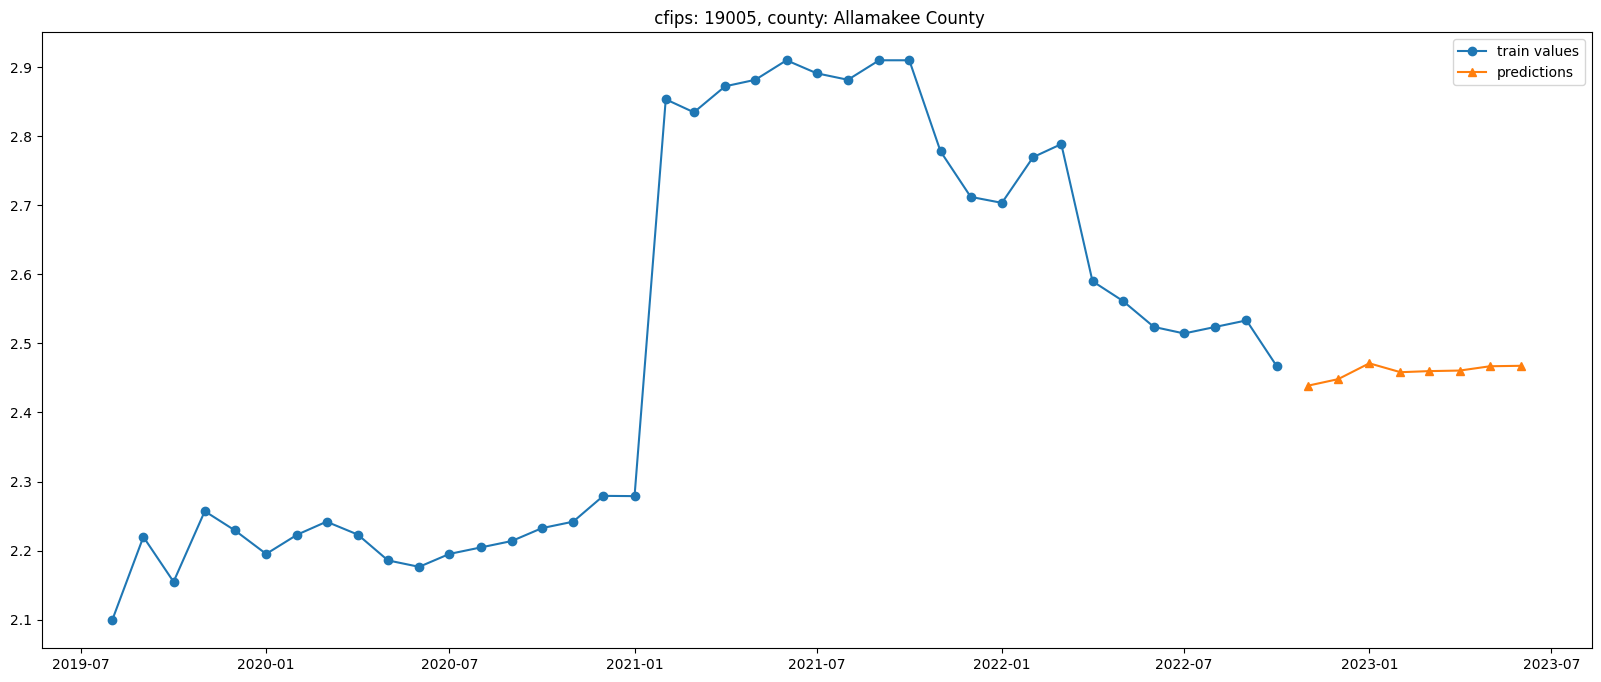

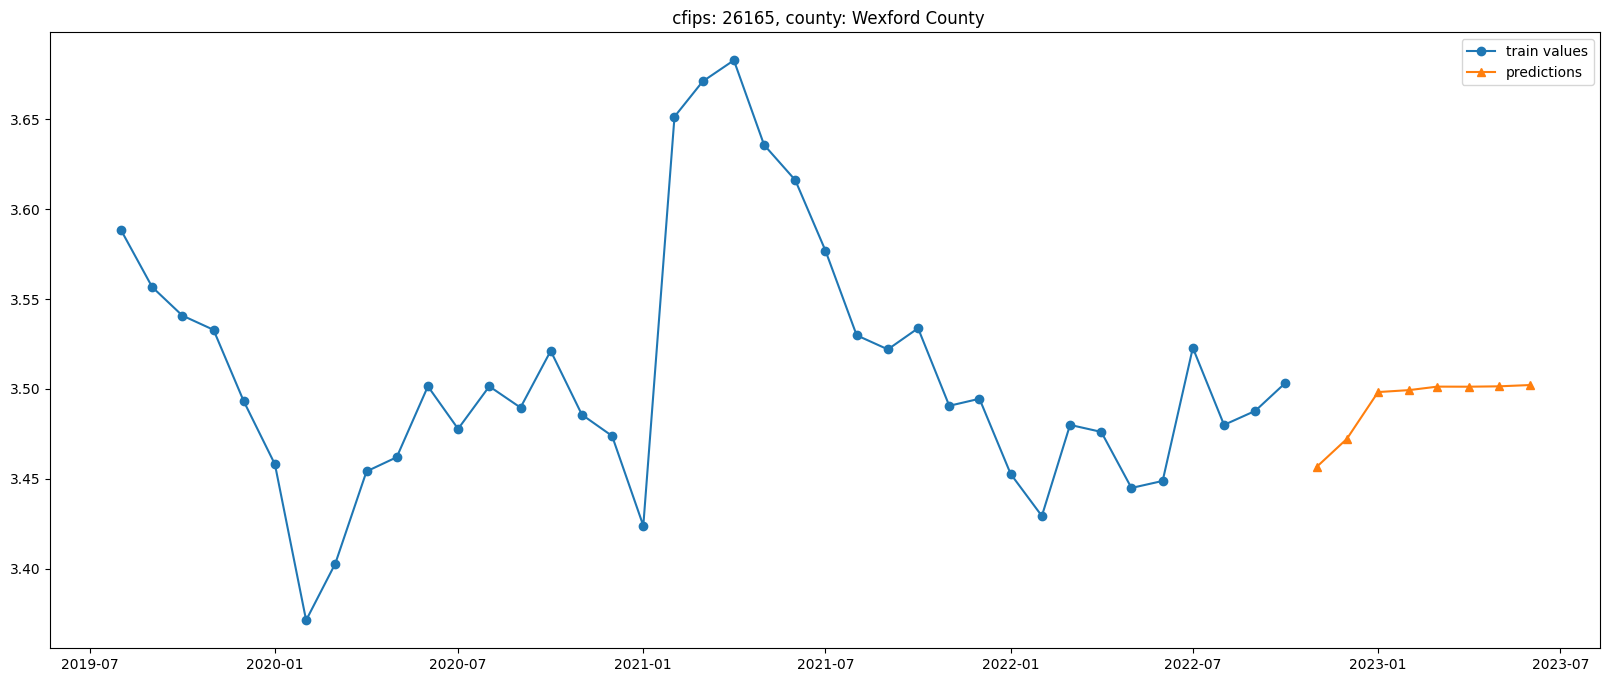

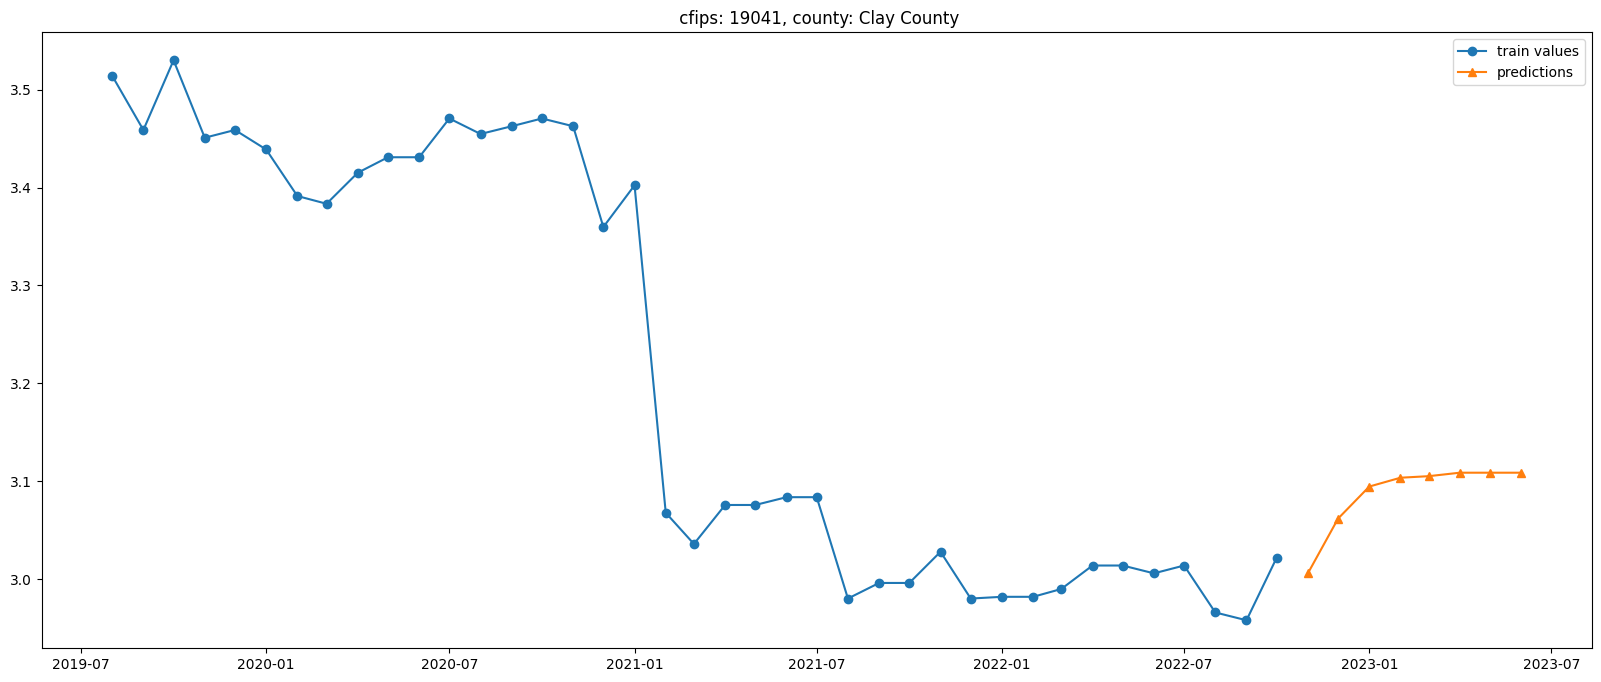

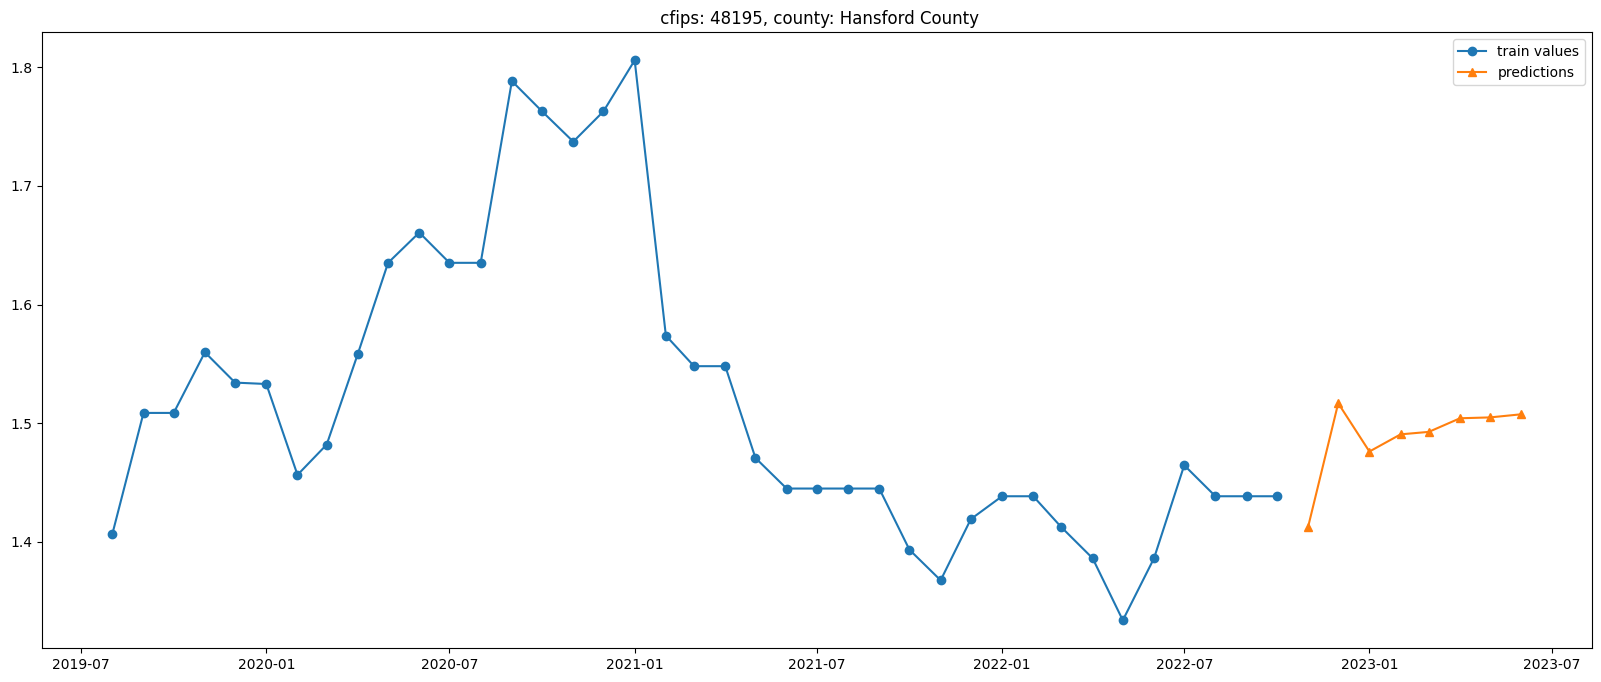

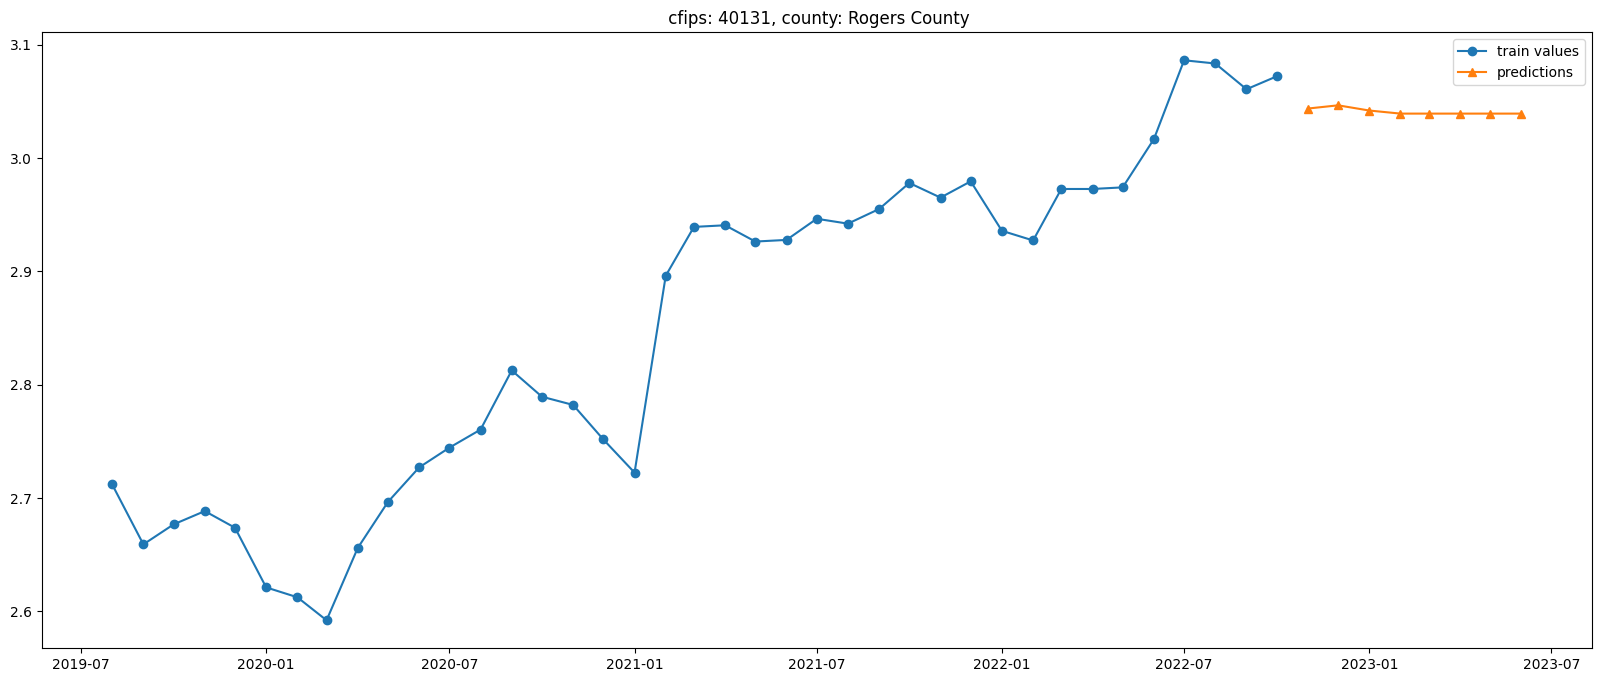

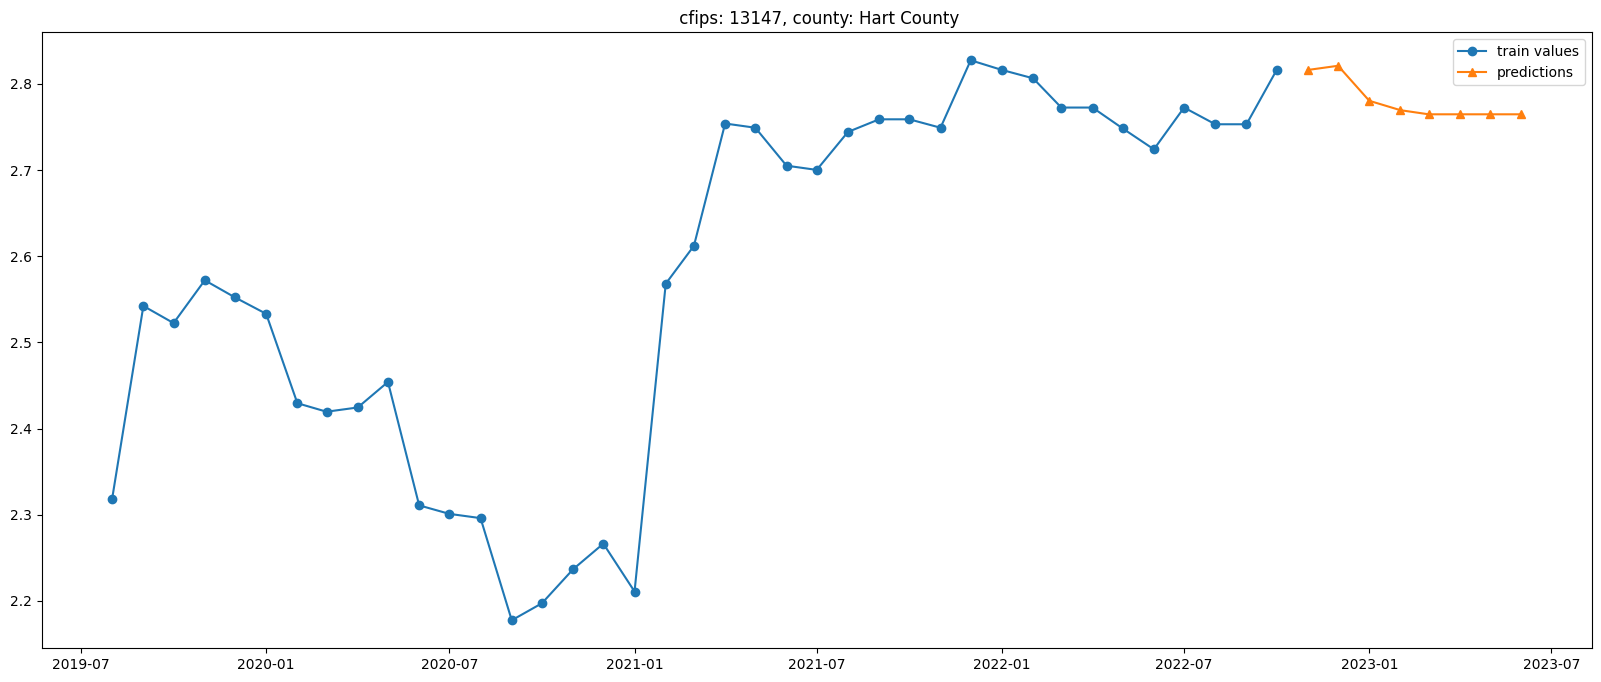

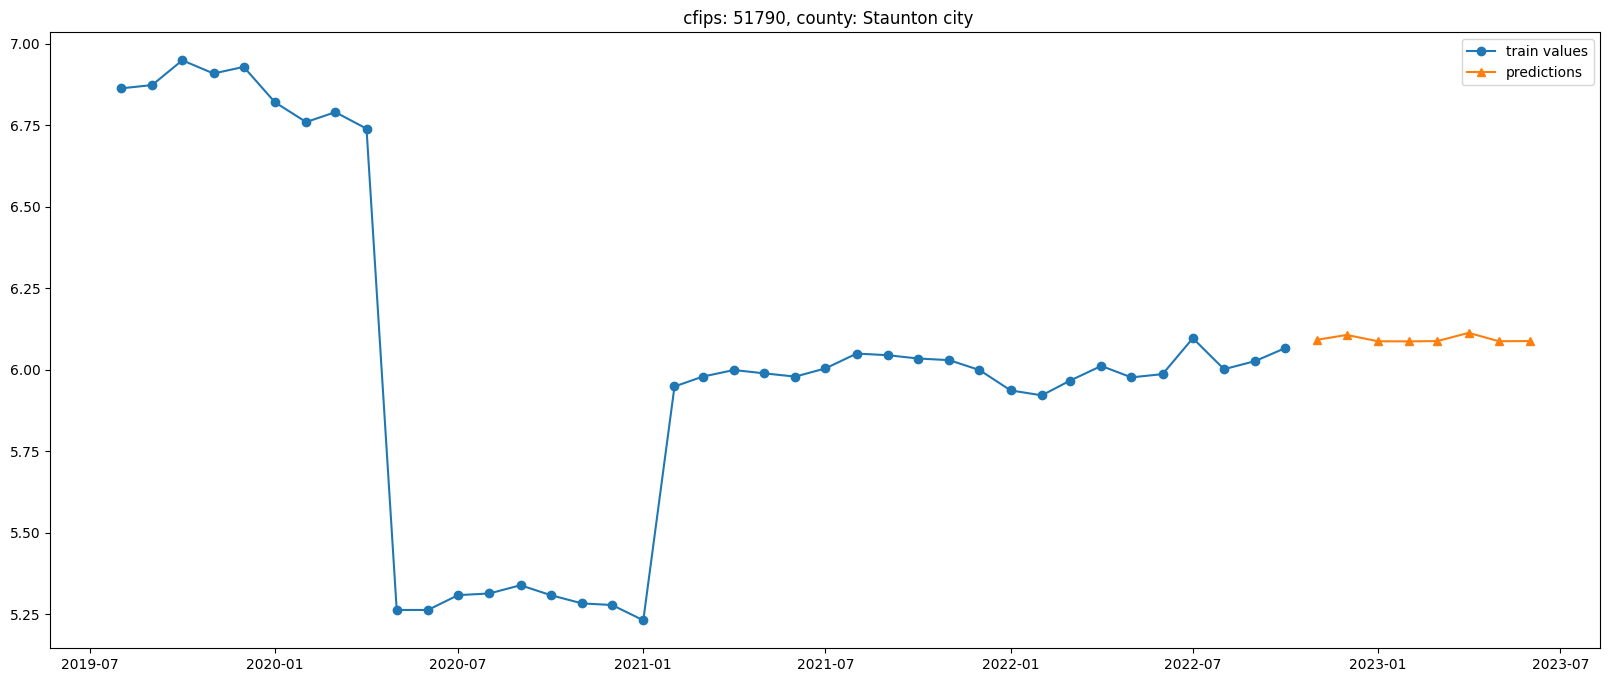

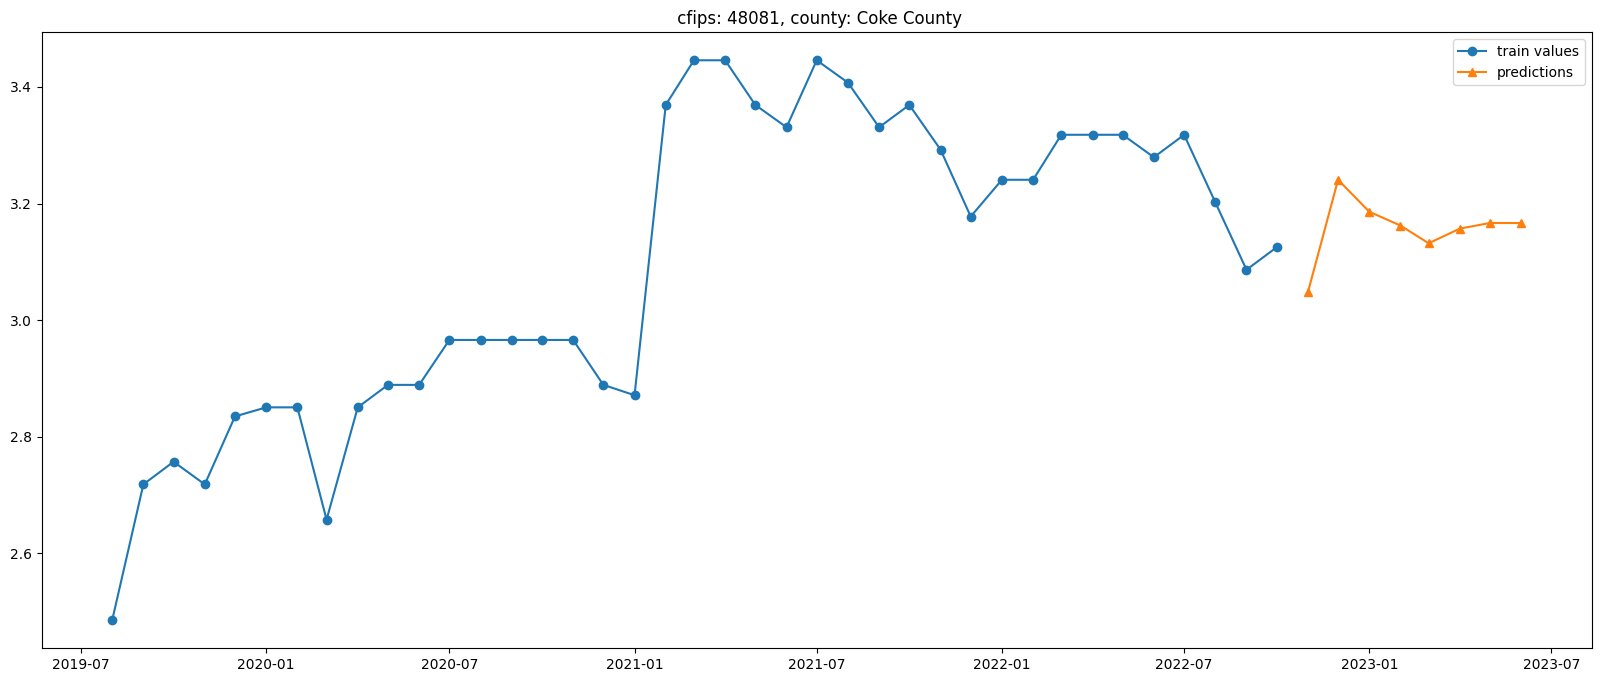

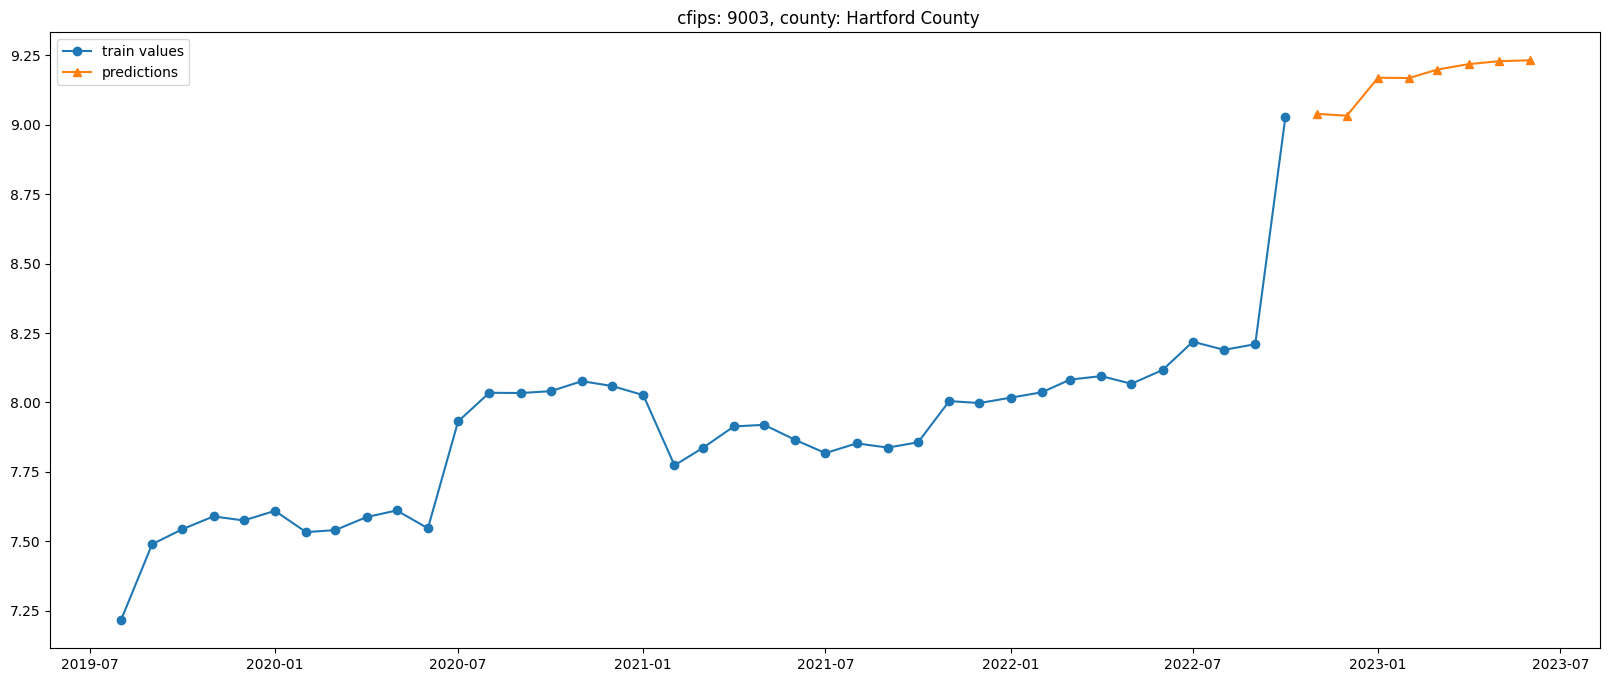

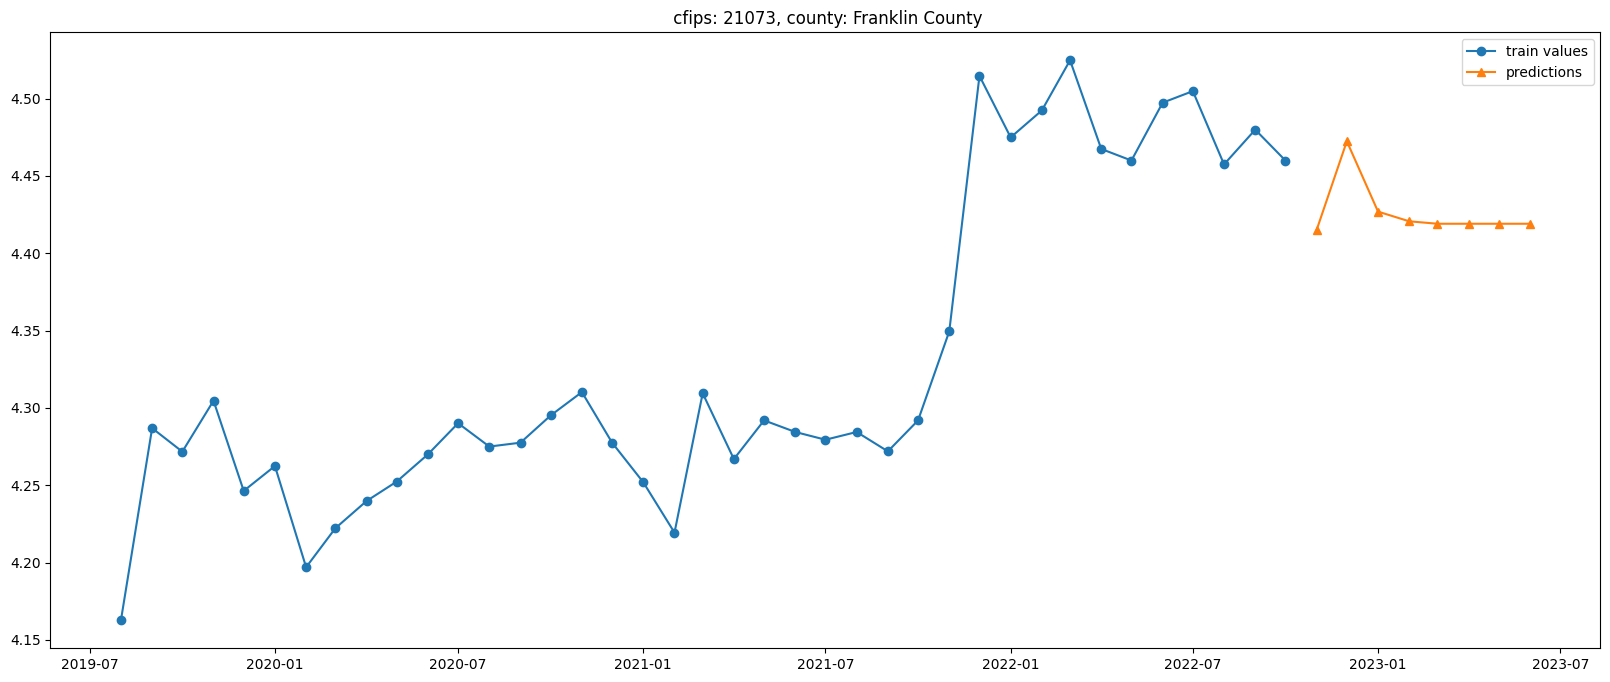

In [149]:
for i in range(10):
    c = np.random.choice(ids)
    plot_df = train[train["cfips"] == c].copy()
    test_plot = test[test["cfips"] == c].copy()
    plot_df["first_day_of_month"] = pd.to_datetime(plot_df["first_day_of_month"])
    test_plot["first_day_of_month"] = pd.to_datetime(test_plot["first_day_of_month"])
    last_target = plot_df["microbusiness_density"].values[-1]

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    plt.plot(
        plot_df["first_day_of_month"],
        plot_df["microbusiness_density"],
        "-o",
        label="train values",
    )
    plt.plot(
        test_plot["first_day_of_month"],
        test_plot["microbusiness_density"],
        "-^",
        label="predictions",
    )
    plt.title(f" cfips: {c}, county: {plot_df['county'].values[0]}")
    plt.legend()
    plt.show()

In [153]:
# transform microbusiness density to 2022 pop
COLS = ["GEO_ID", "NAME", "S0101_C01_026E"]
pop_2020 = pd.read_csv(
    "../data/raw/ACSST5Y2020.S0101-Data.csv", usecols=COLS, dtype="object"
)
pop_2021 = pd.read_csv(
    "../data/raw/ACSST5Y2021.S0101-Data.csv", usecols=COLS, dtype="object"
)
pop_2020 = pop_2020.iloc[1:]
pop_2020 = pop_2020.astype({"S0101_C01_026E": "int"})

pop_2021 = pop_2021.iloc[1:]
pop_2021 = pop_2021.astype({"S0101_C01_026E": "int"})

pop_2020["cfips"] = pop_2020.GEO_ID.apply(lambda x: int(x.split("US")[-1]))
adult2020 = pop_2020.set_index("cfips").S0101_C01_026E.to_dict()

pop_2021["cfips"] = pop_2021.GEO_ID.apply(lambda x: int(x.split("US")[-1]))
adult2021 = pop_2021.set_index("cfips").S0101_C01_026E.to_dict()

pop_2020["mnoshitel"] = pop_2020["S0101_C01_026E"] / pop_2021["S0101_C01_026E"]

pop_2020 = pop_2020[["cfips", "mnoshitel"]]
pop_2020.set_index("cfips", inplace=True)

In [160]:
pop_2020

,mnoshitel
cfips,
1001,0.956299
1003,0.961770
1005,0.990448
1007,0.999438
1009,0.981903
...,...
72145,0.927787
72147,1.018343
72149,0.973780


In [167]:
temp_test = test.copy()
temp_test = temp_test.join(pop_2020, on="cfips", how="left")
mask = temp_test["first_day_of_month"] > "2022-12-01"
temp_test.loc[mask, "microbusiness_density"] = (
    temp_test.loc[mask, "microbusiness_density"] * temp_test.loc[mask, "mnoshitel"]
)

In [168]:
test

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.442677
3135,1001_2022-12-01,1001,2022-12-01,3.470915
6270,1001_2023-01-01,1001,2023-01-01,3.482062
9405,1001_2023-02-01,1001,2023-02-01,3.502117
12540,1001_2023-03-01,1001,2023-03-01,3.488593
...,...,...,...,...
12539,56045_2023-02-01,56045,2023-02-01,1.815876
15674,56045_2023-03-01,56045,2023-03-01,1.825683
18809,56045_2023-04-01,56045,2023-04-01,1.828009
21944,56045_2023-05-01,56045,2023-05-01,1.837555


In [170]:
test["microbusiness_density"] = temp_test["microbusiness_density"]

## Persist

In [171]:
result = test[["row_id", "microbusiness_density"]]
result.to_csv("../data/submissions/submission_ml.csv", index=False)

## DL

In [179]:
import tensorflow as tf
import math

In [191]:
def build_model():
    inp = tf.keras.Input(shape=(49, 1))
    x = tf.keras.layers.GRU(units=128, return_sequences=False)(inp)
    x = tf.keras.layers.Dense(1, activation="linear")(x)
    model = tf.keras.Model(inputs=inp, outputs=x)

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.MeanSquaredError()
    model.compile(loss=loss, optimizer=opt)

    return model

In [197]:
model = build_model()

In [198]:
model.summary()
LR_MAX = 0.001
LR_MIN = 1e-6
EPOCHS = 70
BATCH_SIZE = 100

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 49, 1)]           0         
                                                                 
 gru_4 (GRU)                 (None, 128)               50304     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________


Learning rate schedule: 0.001 to 0.001 to 1e-06


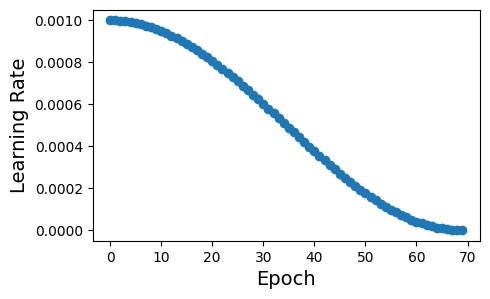

In [194]:
# a simple cosine learning rate without restart
def lrfn(epoch_i, EPOCHS):
    decay_total_epochs = EPOCHS - 1
    phase = math.pi * epoch_i / decay_total_epochs  # 0 ~ pi
    cosine_decay = 0.5 * (1 + math.cos(phase))
    lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN

    return lr


rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x, EPOCHS) for x in rng]
plt.figure(figsize=(5, 3))
plt.plot(rng, lr_y, "-o")
print(
    "Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(
        lr_y[0], max(lr_y), lr_y[-1]
    )
)
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=0)
plt.xlabel("Epoch", size=14)
plt.ylabel("Learning Rate", size=14)
plt.show()

In [199]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))
# train with gpu
result = None
with tf.device("/GPU:0"):
    # result = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks = [LR])
    result = model.fit(
        X,
        y,
        epochs=EPOCHS,
    )

Num GPUs Available:  0
Epoch 1/70
1666/1666 [==============================] - 26s 14ms/step - loss: 15.3879
Epoch 2/70
1666/1666 [==============================] - 24s 14ms/step - loss: 10.9167
Epoch 3/70
1666/1666 [==============================] - 24s 14ms/step - loss: 9.7133
Epoch 4/70
1666/1666 [==============================] - 24s 14ms/step - loss: 9.2833
Epoch 5/70
1666/1666 [==============================] - 24s 14ms/step - loss: 8.9887
Epoch 6/70
1666/1666 [==============================] - 24s 15ms/step - loss: 8.8749
Epoch 7/70
1666/1666 [==============================] - 25s 15ms/step - loss: 8.7682
Epoch 8/70
1666/1666 [==============================] - 24s 15ms/step - loss: 8.7984
Epoch 9/70
1666/1666 [==============================] - 24s 15ms/step - loss: 8.6387
Epoch 10/70
1666/1666 [==============================] - 24s 15ms/step - loss: 8.5624
Epoch 11/70
1666/1666 [==============================] - 24s 14ms/step - loss: 8.7215
Epoch 12/70
1666/1666 [===============

KeyboardInterrupt: 